1.1  Prepare the Dataset

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

(train_ds,test_ds),ds_info=tfds.load('cifar10',split=['train','test'],as_supervised=True,with_info=True)

#Taking only living beings in the dataset and excluding the rest
not_required_labels = [0,1,9,8]
depth = 10 - len(not_required_labels)
for i in not_required_labels:
  train_ds = train_ds.filter(lambda img, label: label != i)
  test_ds = test_ds.filter(lambda img, label: label != i)

def prepare_cifar_data(cifar):
  #Take a single color channel

  # cifar = cifar.map(lambda img, target: (tf.image.rgb_to_grayscale(img), target))
  #convert data from uint8 to float32
  cifar = cifar.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
  cifar = cifar.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot targets
  cifar = cifar.map(lambda img, target: (img, tf.one_hot(target, depth=depth)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  cifar = cifar.cache()
  #shuffle, batch, prefetch
  cifar = cifar.shuffle(10000)
  cifar = cifar.batch(100)
  cifar = cifar.prefetch(50)
  #return preprocessed dataset
  return cifar

train_dataset = train_ds.apply(prepare_cifar_data)
test_dataset = test_ds.apply(prepare_cifar_data)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteKHBH2S/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteKHBH2S/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
print(ds_info)

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir=PosixGPath('/tmp/tmp2dtlpvmatfds'),
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning mult

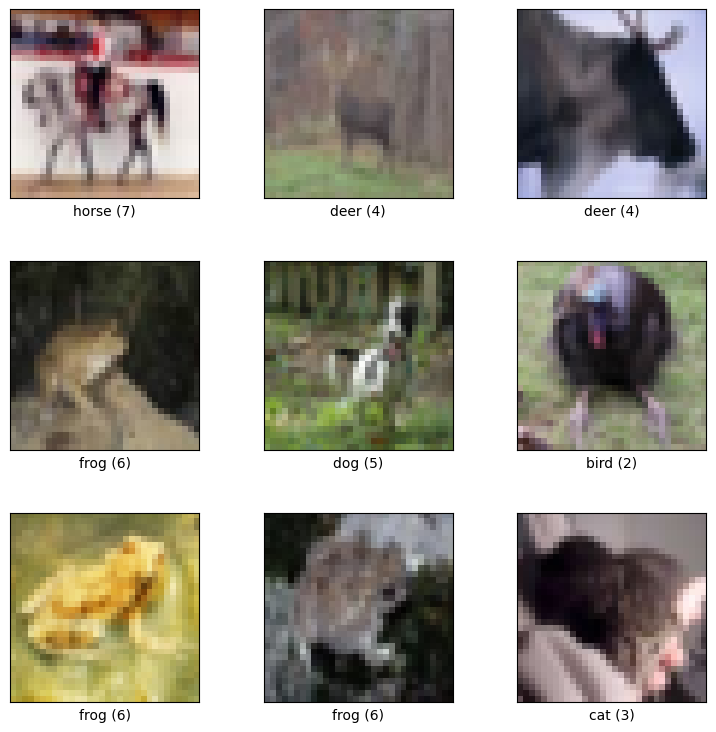

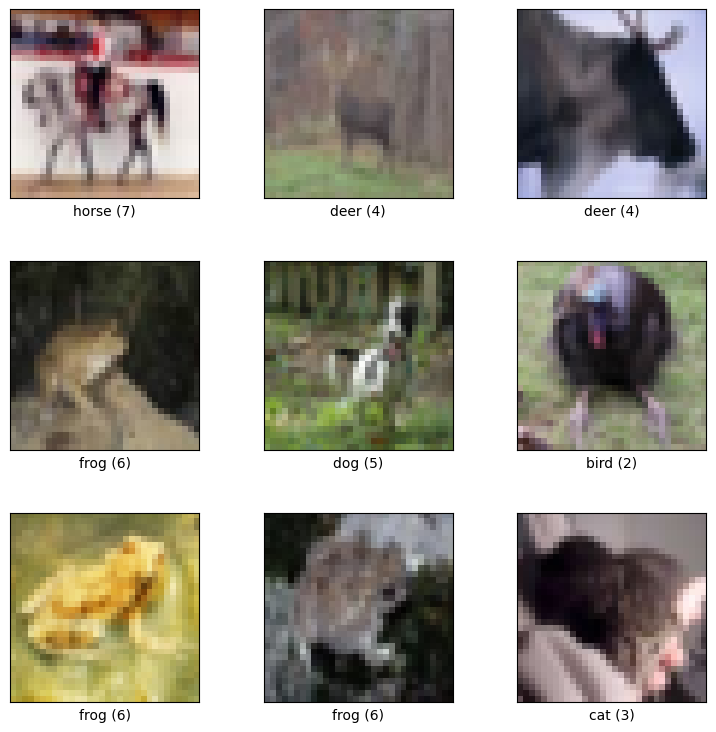

In [ ]:
tfds.show_examples(train_ds ,ds_info)

1.2. The CNN Model

In [ ]:
from tensorflow.keras.layers import Dense

class ResidualConnectedCNNLayer(tf.keras.layers.Layer):
  def __init__(self, num_filters):
    super(ResidualConnectedCNNLayer, self).__init__()
    self.conv = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, padding='same', activation='relu')

  def call(self, x):
    c = self.conv(x)
    x = c+x
    return x

class ResidualConnectedCNNBlock(tf.keras.layers.Layer):
  def __init__(self, depth, layers):
    super(ResidualConnectedCNNBlock, self).__init__()
    self.deeper_layer = tf.keras.layers.Conv2D(filters=depth, kernel_size=3, padding='same', activation='relu')
    self.layers = [ResidualConnectedCNNLayer(depth) for _ in range(layers)]

  def call(self, x):
    x = self.deeper_layer(x)
    for layer in self.layers:
      x = layer(x)
    return x

class ResiConvMix(tf.keras.Model):
    def __init__(self, convlayer_length_list):
        super(ResiConvMix, self).__init__()

        self.convlayer_length_list = convlayer_length_list
        self.convlayer1 = ResidualConnectedCNNBlock(self.convlayer_length_list[0],4)
        self.convlayer2 = ResidualConnectedCNNBlock(self.convlayer_length_list[1],4)
        self.pooling1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer3 = ResidualConnectedCNNBlock(self.convlayer_length_list[2],4)
        self.convlayer4 = ResidualConnectedCNNBlock(self.convlayer_length_list[3],4)
        self.pooling2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer5 = tf.keras.layers.Conv2D(filters= self.convlayer_length_list[4], kernel_size=3, padding='same', activation='relu')
        self.convlayer6 = tf.keras.layers.Conv2D(filters= self.convlayer_length_list[5], kernel_size=3, padding='same', activation='relu')
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()

        self.flatten = tf.keras.layers.Flatten()
        self.out = tf.keras.layers.Dense(depth, activation='softmax')

    def call(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.pooling1(x)
        x = self.convlayer3(x)
        x = self.convlayer4(x)
        x = self.pooling2(x)
        x = self.convlayer5(x)
        x = self.convlayer6(x)
        x = self.global_pool(x)
        x = self.flatten(x)
        x = self.out(x)
        return x


1.3. Training the network

In [ ]:
train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []

def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  train_accuracy = []
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
  sample_train_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
  sample_train_accuracy = np.mean(sample_train_accuracy)
  train_accuracy.append(np.mean(sample_train_accuracy))
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.build(model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss, train_accuracy

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

no_of_epochs = 10
learning_rate = 0.0001
# Initialize the model.
model = ResiConvMix([30,30,60,60,30,30])
# Initialize the loss: categorical cross entropy.
loss_function = tf.keras.losses.CategoricalFocalCrossentropy()

# Initialize the optimizer: SGD with default parameters.
optimizer = tf.keras.optimizers.Adam(learning_rate)


def training_loop(train_ds = train_dataset, test_ds = test_dataset, model = model, no_of_epochs = no_of_epochs, loss_function = loss_function, optimizer = optimizer):
  # We train for num_epochs epochs.
  for epoch in range(no_of_epochs):
    if epoch>=1:
      print(f'Epoch: {str(epoch)} starting with accuracy {np.round(test_accuracies[-1]*100,2)}')

    #training (and checking in with training)
    epoch_loss_agg = []
    epoch_accuracy_agg = []
    for input,target in train_dataset:
        train_loss,train_accuracy  = train_step(model, input, target, loss_function, optimizer)
        epoch_loss_agg.append(train_loss)
        epoch_accuracy_agg.append(train_accuracy)

    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    #track training loss
    train_accuracies.append(tf.reduce_mean(epoch_accuracy_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, loss_function)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

In [ ]:
def visualization():
  """ Visualizes accuracy and loss for training and test data using the mean of each epoch.
  Loss is displayed in a regular line, accuracy in a dotted line.
  Training data is displayed in blue, test data in red.
"""

  plt.figure()
  plt.plot(train_losses , "b-")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Train Loss")
  plt.show()

  plt.figure()
  plt.plot(test_losses , "r-")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Test Loss")
  plt.show()

  plt.figure()
  plt.plot( train_accuracies , "b:")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Train Accuracy")
  plt.show()

  plt.figure()
  plt.plot( test_accuracies , "r:")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Test Accuracy")
  plt.show()

In [ ]:
training_loop()
visualization()

Epoch: 1 starting with accuracy 29.88
Epoch: 2 starting with accuracy 29.92
Epoch: 3 starting with accuracy 33.08
Epoch: 4 starting with accuracy 33.43
Epoch: 5 starting with accuracy 35.05
Epoch: 6 starting with accuracy 36.03
Epoch: 7 starting with accuracy 37.78
Epoch: 8 starting with accuracy 38.53
Epoch: 9 starting with accuracy 39.15
Epoch: 10 starting with accuracy 38.48


In [ ]:
learning_rate_list = [0.00001, 0.001, 0.01, 0.001, 0.001, 0.01, 0.001, 0.00001]
conv_length_list = [[25,25,50,50,25,25],[25,25,50,50,25,25],[25,25,50,50,25,25],[25,25,50,50,25,25],[50,50,100,100,50,50],[50,50,100,100,50,50],[50,50,100,100,50,50],[50,50,100,100,50,50]]

cce = tf.keras.losses.CategoricalCrossentropy()
cfce = tf.keras.losses.CategoricalFocalCrossentropy()
loss_function_list = [cce, cce, cfce, cfce, cfce, cfce, cce, cce]

optimisers_list = ['Adam', 'SGD', 'Adam', 'SGD', 'Adam', 'SGD', 'Adam', 'SGD']

for i in range(8):
  tf.keras.backend.clear_session()
  train_losses = []
  test_losses = []
  test_accuracies = []
  train_accuracies = []
  model = ResiConvMix(conv_length_list[i])
  no_of_epochs = 15
  # Initialize the loss
  loss_function = loss_function_list[i]
  # Initialize the optimizer
  if optimisers_list[i]=='Adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate_list[i], ema_momentum = 0.8)
  elif optimisers_list[i]=='SGD':
    optimizer = tf.keras.optimizers.SGD(learning_rate_list[i])

  print('Setting {} of 8'.format(i+1))
  print('No_of_Epochs: {}'.format(no_of_epochs))
  print('Optimizer: {}'.format(optimisers_list[i]))
  print('Layer Sizes: {}'.format(conv_length_list[i]))

  training_loop(model = model, no_of_epochs = no_of_epochs, optimizer = optimizer)
  visualization()